# 📊 Анализ данных о заказах

## Описание проекта
Анализ данных о заказах из базы данных PostgreSQL для выявления бизнес-инсайтов и паттернов покупок.

## 1. Импорт библиотек и настройка окружения

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import numpy as np

from psycopg2.extras import RealDictCursor
import psycopg2
import warnings
from dotenv import load_dotenv

warnings.filterwarnings('ignore')
load_dotenv('.env')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

## 2. Подключение к базе данных 

In [148]:
db_config = {
    'dbname': os.getenv('POSTGRES_DB', 'ecommerse_system'),
    'user': os.getenv('POSTGRES_USER', 'user'),
    'password': os.getenv('POSTGRES_PASSWORD', 'password'),
    'host': os.getenv('POSTGRES_HOST', 'localhost'),
    'port': os.getenv('POSTGRES_PORT', '5432')
}

conn = None
try:
    conn = psycopg2.connect(
        dbname=db_config['dbname'],
        user=db_config['user'],
        password=db_config['password'],
        host=db_config['host'],
        port=db_config['port']
    )
    print("Успешное подключение к базе данных!")
except Exception as e:
    print(f"Ошибка подключения: {e}")

table_name = "orders"

try:    
    with conn.cursor(cursor_factory=RealDictCursor) as cur:
        cur.execute(f"SELECT * FROM {table_name}")
        rows = cur.fetchall()

        table_dataframe = pd.DataFrame(rows)
        print(f"Таблица '{table_name}': {len(table_dataframe)} строк, {len(table_dataframe.columns)} столбцов")
        
except Exception as e:
    print(f"Ошибка загрузки таблицы '{table_name}': {e}")
finally:
    if conn:
        conn.close()

Успешное подключение к базе данных!
Таблица 'orders': 26760 строк, 9 столбцов


## 3. Загрузка данных из таблицы orders

In [149]:
max_rows = 10
print("=" * 100)
print("ТАБЛИЦА ЗАКАЗОВ".center(100))
print("=" * 100)
print()

col_widths = {}
for col in table_dataframe.columns:
    col_widths[col] = max(len(str(col)), 15)

headers = []
for col in table_dataframe.columns:
    col_name = str(col)
    if len(col_name) > 15:
        col_name = col_name[:12] + "..."
    headers.append(f"{col_name:<{col_widths[col]}}")

print(" | ".join(headers))
print("-" * (sum(col_widths.values()) + 3 * (len(col_widths) - 1)))

for i in range(min(len(table_dataframe), max_rows)):
    row_values = []
    for col in table_dataframe.columns:
        val = table_dataframe.iloc[i][col]
        
        if 'price' in col.lower() or 'amount' in col.lower():
            val_str = f"{float(val):,.0f} руб."
        elif 'timestamp' in col.lower():
            val_str = str(val)[:16]  
        elif 'name' in col.lower():
            val_str = str(val)[:20] + "..." if len(str(val)) > 20 else str(val)
        elif 'category' in col.lower() or 'city' in col.lower():
            val_str = str(val)[:15] + "..." if len(str(val)) > 15 else str(val)
        else:
            val_str = str(val)
        
        row_values.append(f"{val_str:<{col_widths[col]}}")
    
    print(" | ".join(row_values))

print()
print(f"Показано: {min(len(table_dataframe), max_rows)} из {len(table_dataframe)} записей")
print("=" * 100)

                                          ТАБЛИЦА ЗАКАЗОВ                                           

id              | order_timestamp | product_name    | category        | price           | quantity        | city            | customer_name   | total_amount   
---------------------------------------------------------------------------------------------------------------------------------------------------------------
1               | 2026-01-14 11:28 | Наушники        | Электроника     | 5,136 руб.      | 1               | Ростов-на-Дону  | Пелагея Болеславовна... | 5,136 руб.     
2               | 2026-01-14 11:28 | Стул            | Мебель          | 2,607 руб.      | 1               | Волгоград       | Антонина Викторовна ... | 2,607 руб.     
3               | 2026-01-14 11:28 | Кофеварка       | Бытовая техника | 11,121 руб.     | 1               | Челябинск       | Анжела Георгиевна Во... | 11,121 руб.    
4               | 2026-01-14 11:28 | Кофеварка       | Бытовая техника 

## 📊 Визуализация данных о заказах

Создадим интерактивные графики для анализа:
1. Распределение выручки по категориям товаров
2. Динамика продаж по времени
3. Топ товаров по выручке
4. География продаж
5. Анализ среднего чека

In [150]:
df_viz = table_dataframe.copy()

df_viz['order_timestamp'] = pd.to_datetime(df_viz['order_timestamp'])
df_viz['price'] = df_viz['price'].astype(float)
df_viz['total_amount'] = df_viz['total_amount'].astype(float)

df_viz['hour'] = df_viz['order_timestamp'].dt.hour
df_viz['day'] = df_viz['order_timestamp'].dt.day_name()
df_viz['date'] = df_viz['order_timestamp'].dt.date
df_viz['week'] = df_viz['order_timestamp'].dt.isocalendar().week

df_viz['order_size'] = pd.qcut(df_viz['total_amount'], 
                                q=3, 
                                labels=['Малый', 'Средний', 'Крупный'])

print(f"Всего заказов: {len(df_viz)}")
print(f"Общая выручка: {df_viz['total_amount'].sum():,.2f} руб.")

Всего заказов: 26760
Общая выручка: 955,303,088.81 руб.


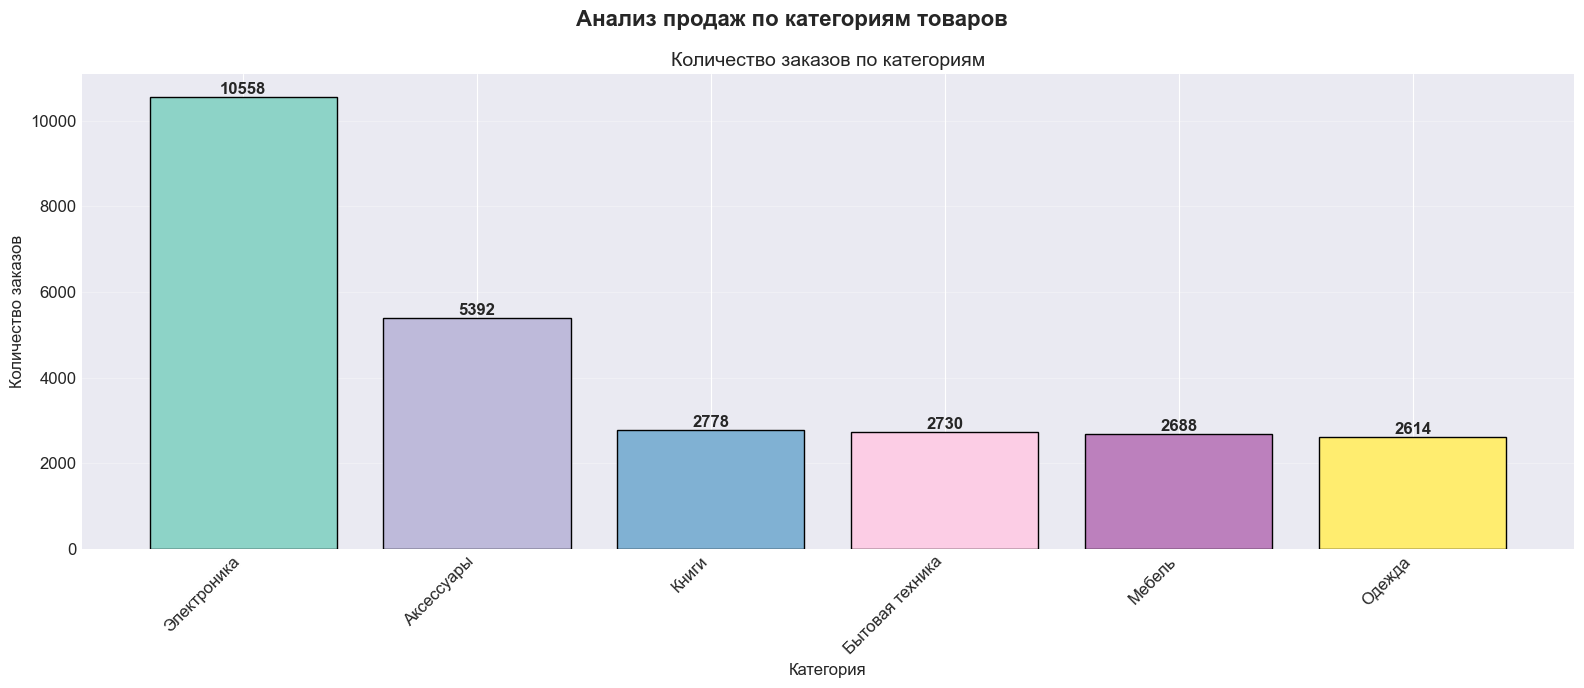


Статистика по категориям:
1. Электроника:
   Выручка: 675,414,969.16 руб.
   Заказов: 10558
   Средний чек: 63,971.87 руб.
2. Аксессуары:
   Выручка: 173,190,687.01 руб.
   Заказов: 5392
   Средний чек: 32,119.93 руб.
3. Бытовая техника:
   Выручка: 49,450,385.05 руб.
   Заказов: 2730
   Средний чек: 18,113.69 руб.
4. Мебель:
   Выручка: 37,765,492.08 руб.
   Заказов: 2688
   Средний чек: 14,049.66 руб.
5. Одежда:
   Выручка: 11,140,505.86 руб.
   Заказов: 2614
   Средний чек: 4,261.86 руб.
6. Книги:
   Выручка: 8,341,049.65 руб.
   Заказов: 2778
   Средний чек: 3,002.54 руб.


In [151]:
fig, axes = plt.subplots(1, 1, figsize=(16, 7))
fig.suptitle('Анализ продаж по категориям товаров', fontsize=16, fontweight='bold')

category_revenue = df_viz.groupby('category')['total_amount'].sum().sort_values(ascending=False)

colors = plt.cm.Set3(np.linspace(0, 1, len(category_revenue)))

axes.set_title('Распределение выручки по категориям', fontsize=14, pad=20)

category_orders = df_viz['category'].value_counts()

bars = axes.bar(range(len(category_orders)), category_orders.values, 
                    color=colors, edgecolor='black', linewidth=1)

for bar in bars:
    height = bar.get_height()
    axes.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold')

axes.set_title('Количество заказов по категориям', fontsize=14)
axes.set_xlabel('Категория')
axes.set_ylabel('Количество заказов')
axes.set_xticks(range(len(category_orders)))
axes.set_xticklabels(category_orders.index, rotation=45, ha='right')
axes.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nСтатистика по категориям:")
for idx, (category, revenue) in enumerate(category_revenue.items(), 1):
    orders = category_orders.get(category, 0)
    avg_check = revenue / orders if orders > 0 else 0
    print(f"{idx}. {category}:")
    print(f"   Выручка: {revenue:,.2f} руб.")
    print(f"   Заказов: {orders}")
    print(f"   Средний чек: {avg_check:,.2f} руб.")

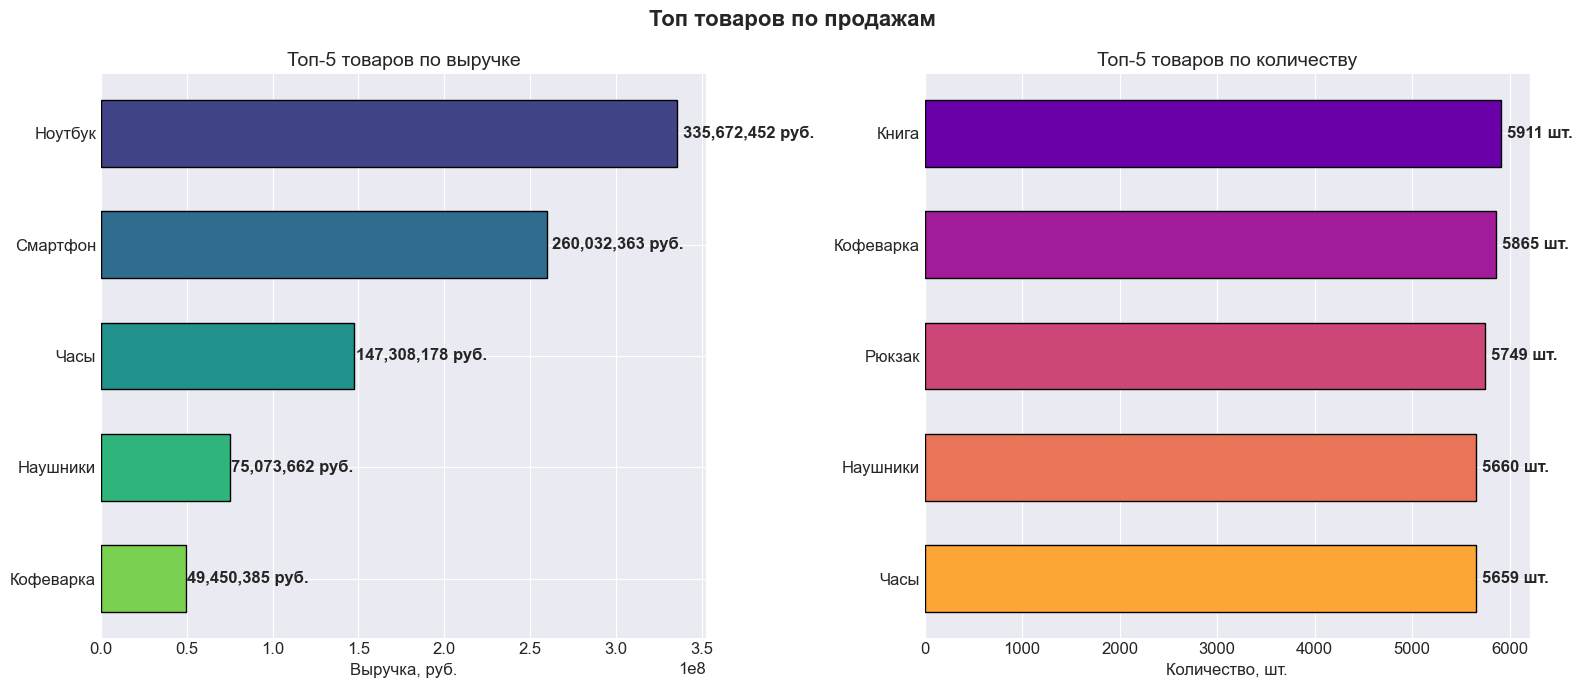

In [152]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Топ товаров по продажам', fontsize=16, fontweight='bold')

top_revenue = df_viz.groupby('product_name')['total_amount'].sum().nlargest(5)

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_revenue)))

bars1 = axes[0].barh(range(len(top_revenue)), top_revenue.values, 
                        color=colors, edgecolor='black', height=0.6)

axes[0].set_title(f'Топ-5 товаров по выручке', fontsize=14)
axes[0].set_xlabel('Выручка, руб.')
axes[0].set_yticks(range(len(top_revenue)))
axes[0].set_yticklabels(top_revenue.index)
axes[0].invert_yaxis()

for bar in bars1:
    width = bar.get_width()
    axes[0].text(width + width*0.01, bar.get_y() + bar.get_height()/2,
                f'{width:,.0f} руб.',
                ha='left', va='center', fontweight='bold')

top_quantity = df_viz.groupby('product_name')['quantity'].sum().nlargest(5)

bars2 = axes[1].barh(range(len(top_quantity)), top_quantity.values,
                        color=plt.cm.plasma(np.linspace(0.2, 0.8, len(top_quantity))),
                        edgecolor='black', height=0.6)

axes[1].set_title('Топ-5 товаров по количеству', fontsize=14)
axes[1].set_xlabel('Количество, шт.')
axes[1].set_yticks(range(len(top_quantity)))
axes[1].set_yticklabels(top_quantity.index)
axes[1].invert_yaxis()

for bar in bars2:
    width = bar.get_width()
    axes[1].text(width + width*0.01, bar.get_y() + bar.get_height()/2,
                f'{int(width)} шт.',
                ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

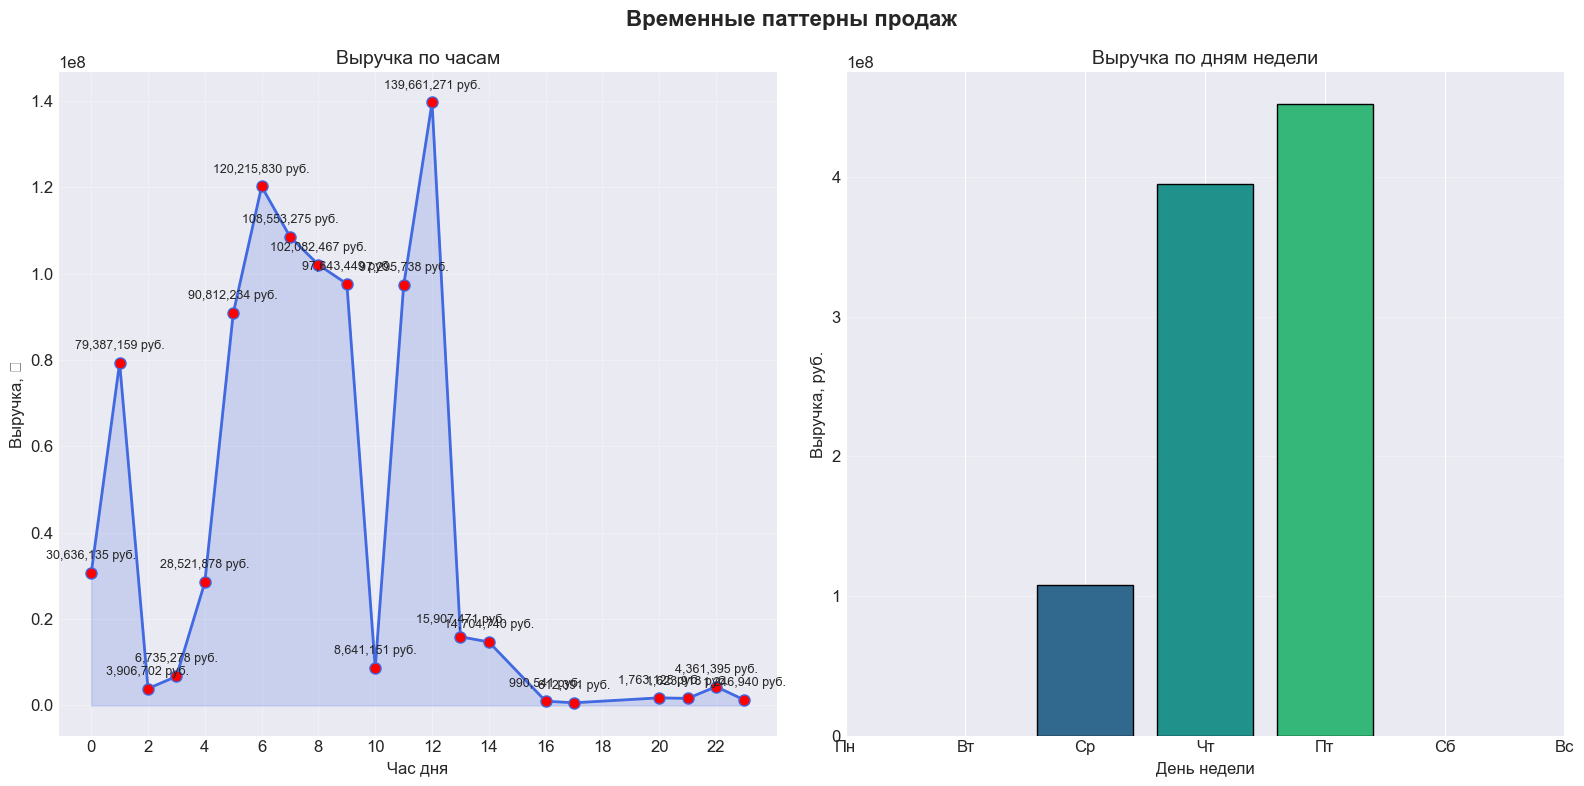


Временная статистика:
• Самый активный час: 12:00 (139,661,271 руб.)
• Самый прибыльный день: Friday (452,533,864 руб.)
• Средняя сумма заказа: 35,699 руб.
• Медианная сумма заказа: 11,654 руб.


In [153]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Временные паттерны продаж', fontsize=16, fontweight='bold')

hourly_sales = df_viz.groupby('hour')['total_amount'].sum()

axes[0].plot(hourly_sales.index, hourly_sales.values, 
                marker='o', linewidth=2, markersize=8,
                color='royalblue', markerfacecolor='red')

axes[0].fill_between(hourly_sales.index, 0, hourly_sales.values,
                        alpha=0.2, color='royalblue')

axes[0].set_title('Выручка по часам', fontsize=14)
axes[0].set_xlabel('Час дня')
axes[0].set_ylabel('Выручка, ₽')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(0, 24, 2))

for hour, sales in hourly_sales.items():
    axes[0].annotate(f'{sales:,.0f} руб.', 
                        xy=(hour, sales),
                        xytext=(0, 10),
                        textcoords='offset points',
                        ha='center', fontsize=9)

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_sales = df_viz.groupby('day')['total_amount'].sum().reindex(day_order)

colors_day = plt.cm.viridis(np.linspace(0, 1, len(daily_sales)))

bars = axes[1].bar(range(len(daily_sales)), daily_sales.values,
                        color=colors_day, edgecolor='black')

axes[1].set_title('Выручка по дням недели', fontsize=14)
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Выручка, руб.')
axes[1].set_xticks(range(len(daily_sales)))
axes[1].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nВременная статистика:")
print(f"• Самый активный час: {hourly_sales.idxmax()}:00 ({hourly_sales.max():,.0f} руб.)")
print(f"• Самый прибыльный день: {daily_sales.idxmax()} ({daily_sales.max():,.0f} руб.)")
print(f"• Средняя сумма заказа: {df_viz['total_amount'].mean():,.0f} руб.")
print(f"• Медианная сумма заказа: {df_viz['total_amount'].median():,.0f} руб.")